Author: fchollet

Adapted from: https://keras.io/examples/generative/neural_style_transfer/


#### Imports
Import the necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display

#### Load base and style reference images
Load the base image from the  `base_image_path ` variable, and the style reference image from the  `style_reference_image_path ` variable. The generated image will be saved with the  `result_prefix ` variable as a prefix. 

In [3]:
base_image_path = keras.utils.get_file("base_image.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Beautiful_waterfall_in_Plitvice_Lakes.jpg/1200px-Beautiful_waterfall_in_Plitvice_Lakes.jpg?20200601185122")
style_reference_image_path = keras.utils.get_file(
    "style_reference.jpg", "https://blocdejavier.files.wordpress.com/2022/03/picasso-retrato-de-dora-maar-1937.jpg"
)
result_prefix = "waterfall_generated"

Display the base image.

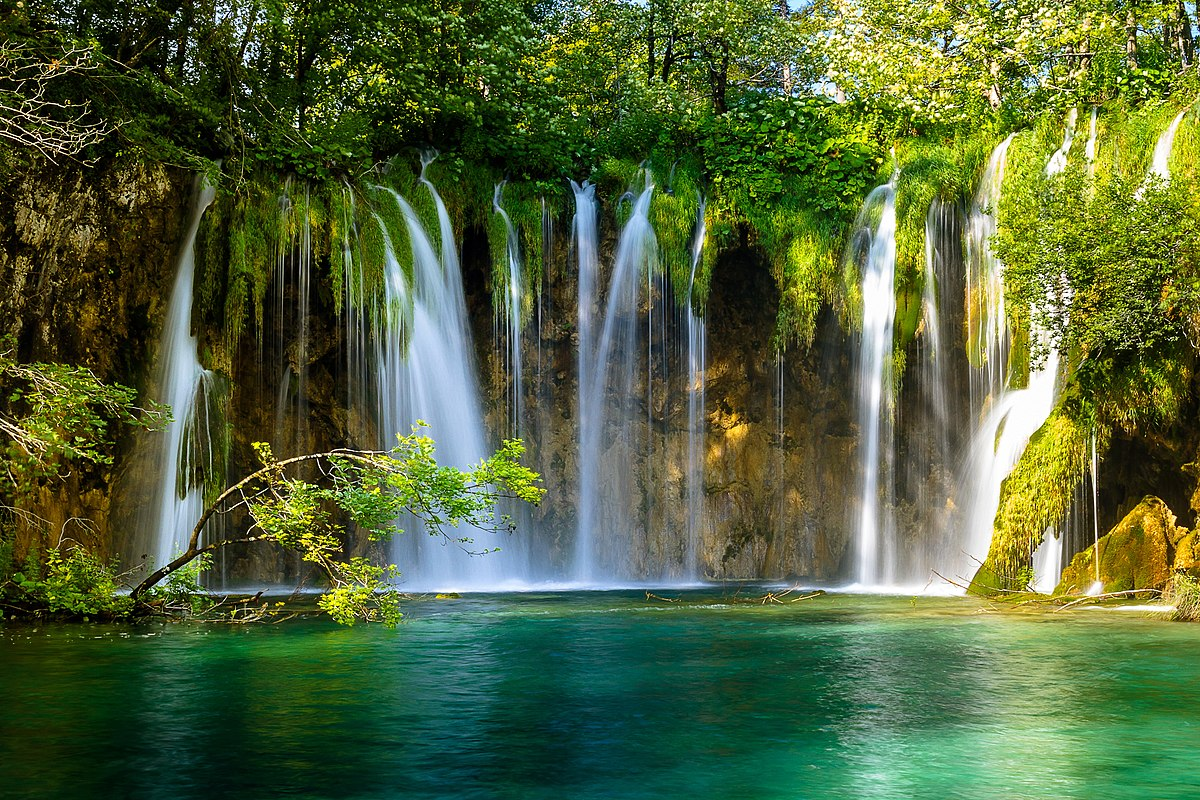

In [4]:
display(Image(base_image_path))

Display the style reference image. 

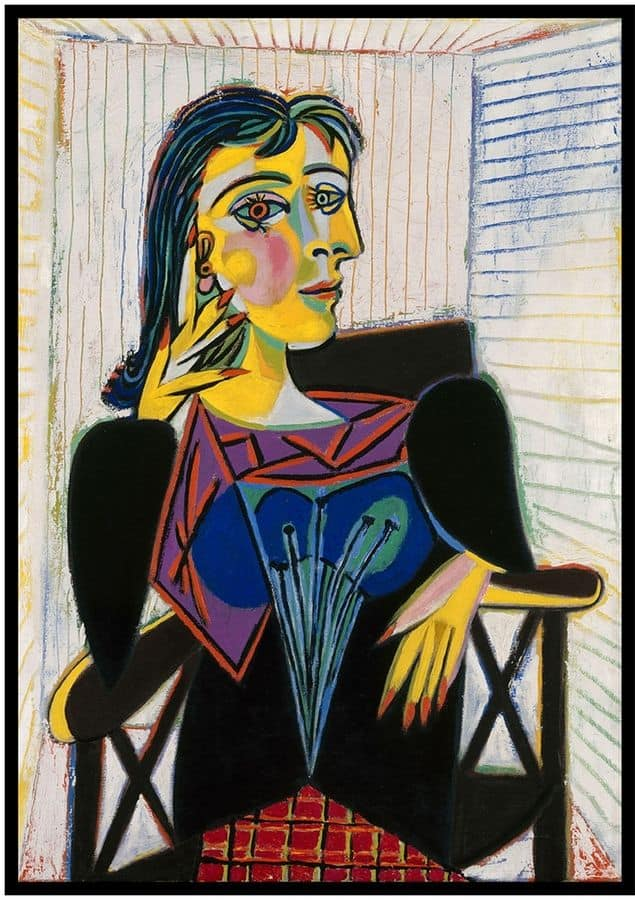

In [5]:
display(Image(style_reference_image_path))

#### Utils - weights and dimensions
Determine the weights to be used in the loss function below and the dimensions of the picture to be generated. 

In [6]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

#### Utils - Preprocessing and Deprocessing Images
Preprocess the images: resize the images to the size specified by the img_nrows and img_ncols variables and apply the VGG19 preprocessing functions to the images. Return the preprocessed images as tensors.  Deprocess the images executes the inverse procedure to turn from tensors to image, this last function is used at the end of the code.

In [7]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

#### Compute Loss
Compute the loss for the combination image, base image, and style reference image. Use the content layer name and style layer names to calculate the content and style losses respectively. Calculate the total variation loss for the combination image. 

In [8]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


#### Model
Create a VGG19 model with weights from the ImageNet dataset, and set the top layers to be excluded. Create a dictionary of the model's layers and their outputs, and use this to create a feature extractor model. This feature extractor model will be used to compute the loss for the combination image, base image, and style reference image.

In [9]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 4s 0us/step


#### Compute Loss and Gradients
Compute the loss and gradients for the combination image, base image, and style reference image. 

In [10]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

#### Optimizing the Combination Image
Use the  `keras.optimizers.SGD` to optimize the combination image. Iterate through 10000 iterations, computing the loss and gradients for the combination image, base image, and style reference image. The gradients are applied to the combination image, and the loss printed every 100 iterations. Finally, the combination image will be saved as an image file.

In [11]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 10000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=11522.87
Iteration 200: loss=8199.07
Iteration 300: loss=7116.77
Iteration 400: loss=6556.67
Iteration 500: loss=6200.04
Iteration 600: loss=5950.28
Iteration 700: loss=5761.57
Iteration 800: loss=5611.86
Iteration 900: loss=5490.53
Iteration 1000: loss=5389.80
Iteration 1100: loss=5303.32
Iteration 1200: loss=5229.21
Iteration 1300: loss=5164.76
Iteration 1400: loss=5108.15
Iteration 1500: loss=5058.16
Iteration 1600: loss=5013.67
Iteration 1700: loss=4973.76
Iteration 1800: loss=4938.08
Iteration 1900: loss=4906.03
Iteration 2000: loss=4877.20
Iteration 2100: loss=4851.09
Iteration 2200: loss=4827.09
Iteration 2300: loss=4805.15
Iteration 2400: loss=4784.88
Iteration 2500: loss=4766.26
Iteration 2600: loss=4749.04
Iteration 2700: loss=4733.06
Iteration 2800: loss=4718.32
Iteration 2900: loss=4704.47
Iteration 3000: loss=4691.48
Iteration 3100: loss=4679.33
Iteration 3200: loss=4667.96
Iteration 3300: loss=4657.28
Iteration 3400: loss=4647.21
Iteration 3500: loss=4

####  Inference
Display the combination image saved at iteration 4000. 

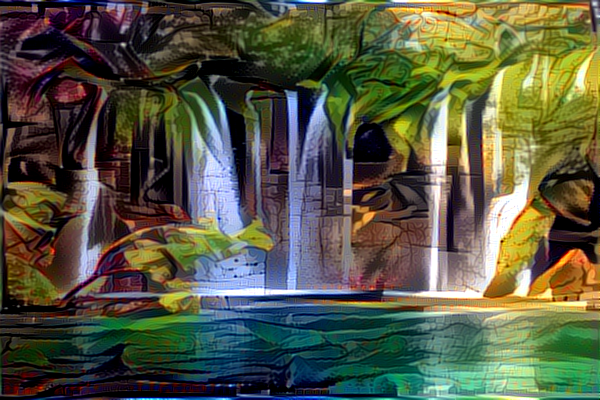

In [12]:
display(Image(result_prefix + "_at_iteration_4000.png"))